<a href="https://colab.research.google.com/github/srv96/AI-ML-TensorFlow/blob/main/Spam_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import tensorflow as tf

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [68]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [69]:
df = pd.read_csv('spam.csv',encoding='ISO-8859-1')
df = df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [70]:
df.columns = ['labels','data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [71]:
df['b_labels'] = df['labels'].map({'ham':0,'spam':1})
Y = df['b_labels'].values

In [72]:
df_train , df_test , Ytrain , Ytest = train_test_split(df['data'],Y,test_size=0.33)

In [73]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.values,Ytrain))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.values,Ytest))

In [74]:
#convert sentence to sequence
MAX_VOCAB_SIZE = 20_000
vectorization = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
)
vectorization.adapt(train_ds.map(lambda x , y : x))

In [75]:
train_ds = train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
V = len(vectorization.get_vocabulary())
print(V)

7536


In [77]:
input_sequences_train = vectorization(df_train.values)
input_sequences_test = vectorization(df_test.values)

In [78]:
input_sequences_train.shape

TensorShape([3733, 115])

In [79]:
input_sequences_test.shape

TensorShape([1839, 171])

In [80]:
T = input_sequences_train.shape[1]
T

115

In [81]:
vectorization2 = tf.keras.layers.TextVectorization(
    max_tokens = MAX_VOCAB_SIZE,
    output_sequence_length = T,
    vocabulary = vectorization.get_vocabulary()
)

In [82]:
D = 20

i = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = vectorization2(i)
x = tf.keras.layers.Embedding(V,D)(x)
x = tf.keras.layers.Conv1D(32,3,activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(64,3,activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(128,3,activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,x)

In [83]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_7                 │ (None, 115)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 115, 20)             │         150,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 113, 32)             │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 37, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 35, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 9, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,713 (717.63 KB)

 Trainable params: 183,713 (717.63 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [85]:
r = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 5
)

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8588 - loss: 0.4499 - val_accuracy: 0.9048 - val_loss: 0.2066
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9569 - loss: 0.1307 - val_accuracy: 0.9837 - val_loss: 0.0533
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9873 - loss: 0.0439 - val_accuracy: 0.9842 - val_loss: 0.0548
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9924 - loss: 0.0262 - val_accuracy: 0.9831 - val_loss: 0.0575
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9966 - loss: 0.0099 - val_accuracy: 0.9853 - val_loss: 0.0590


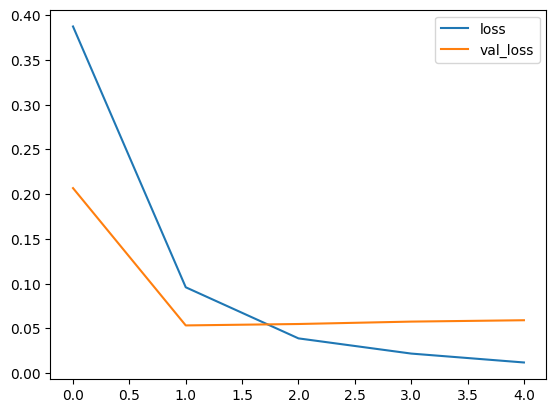

In [86]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

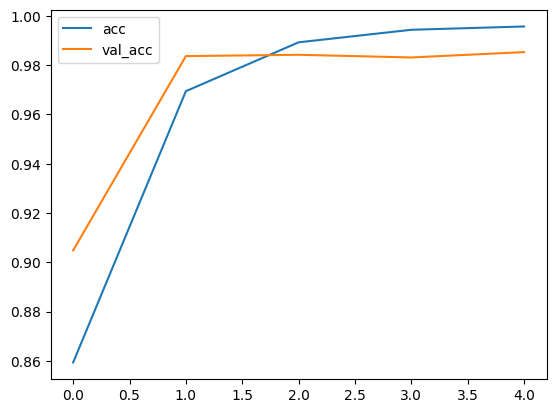

In [87]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [88]:
from sklearn.metrics import f1_score
f1_score(Ytrain, model.predict(df_train.values) > 0.5)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


0.9980842911877394

In [89]:
f1_score(Ytest, model.predict(df_test.values) > 0.5)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9395973154362416

## # converting string to number everytime during training is not feasible so do it once and store it , string take less space then string

In [90]:
MAX_VOCAB_SIZE = 20_000
vectorization_layers_ragged = tf.keras.layers.TextVectorization(
    max_tokens = MAX_VOCAB_SIZE,
    ragged = True,
    output_mode = 'int'
)
vectorization_layers_ragged.adapt(df_train)

In [91]:
#embedding features
V = len(vectorization_layers_ragged.get_vocabulary())

#embedding dimension
D = 20

#hidden state dimension
M = 25

T = train_sequence_pad.shape[1]
D = 1

i = tf.keras.layers.Input(shape=(T,),dtype=tf.int32)
x = tf.keras.layers.Embedding(V,D)(i)
x = tf.keras.layers.Conv1D(32,3,activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(64,3,activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.Conv1D(128,3,activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,x)

In [92]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 162)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 162, 1)              │           7,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 160, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 53, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 51, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 15, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,705 (151.19 KB)

 Trainable params: 38,705 (151.19 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
vectorization_layers_ragged2 = tf.keras.layers.TextVectorization(
    max_tokens = MAX_VOCAB_SIZE,
    output_sequence_length = T,
    vocabulary = vectorization_layers_ragged.get_vocabulary()
)

In [94]:
train_sequence = vectorization_layers_ragged2(df_train.values).numpy()
test_sequence = vectorization_layers_ragged2(df_test.values).numpy()

In [95]:
train_sequence_pad = tf.keras.preprocessing.sequence.pad_sequences(train_sequence, padding='pre')
test_sequence_pad = tf.keras.preprocessing.sequence.pad_sequences(test_sequence, padding='pre')

In [96]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequence_pad, Ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sequence_pad, Ytest))

batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [97]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

r = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = 5
)

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8465 - loss: 0.4781 - val_accuracy: 0.8782 - val_loss: 0.3606
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8537 - loss: 0.4029 - val_accuracy: 0.8673 - val_loss: 0.3143
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8755 - loss: 0.2916 - val_accuracy: 0.9679 - val_loss: 0.1188
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9690 - loss: 0.1015 - val_accuracy: 0.9793 - val_loss: 0.0673
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9778 - loss: 0.0690 - val_accuracy: 0.9821 - val_loss: 0.0557


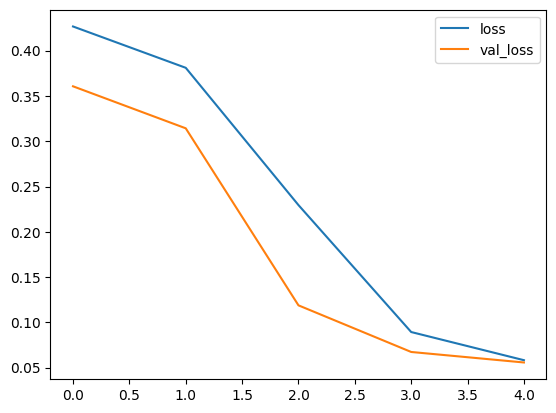

In [98]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

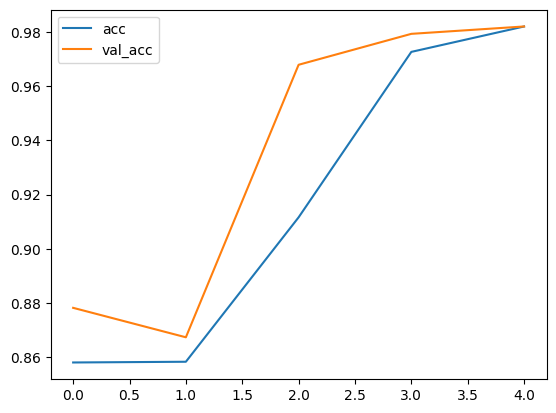

In [99]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [100]:
f1_score(Ytrain, model.predict(vectorization_layers_ragged2(df_train.values)) > 0.5)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


0.9481037924151696

In [101]:
f1_score(Ytest, model.predict(vectorization_layers_ragged2(df_test.values)) > 0.5)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9258426966292135